## Credit Card Fraud Prediction with Sklearn

This is a demonstration on how to use logistic regression in [scikit] learn(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
The dataset is part of the kaggle competition described [here](https://www.kaggle.com/c/ieee-fraud-detection/data). Please make sure to download and save the data into the same directory as this notebook before running the code below.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import data
id_raw_df = pd.read_csv("train_identity.csv")
id_trans_df = pd.read_csv("train_transaction.csv")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
print(id_raw_df.shape)
print(id_trans_df.shape)

(144233, 41)
(590540, 394)


In [5]:
# Merge the two dfs by TransactionID
train_full_df = pd.merge(id_trans_df, id_raw_df, on = "TransactionID", how="left")

In [6]:
train_full_df.shape

(590540, 434)

In [7]:
print("Identitiy df:", id_raw_df.memory_usage().sum() / 1024**2, "Mb")
print("Transaction df:", id_trans_df.memory_usage().sum() / 1024**2, "Mb")

Identitiy df: 45.11695098876953 Mb
Transaction df: 1775.1524047851562 Mb


The two original dataframes, in particular `id_trans_df`, are pretty big and using up a lot of memory. Since we have no more use for them after the merging step above, let's get rid of them.

In [8]:
del id_raw_df, id_trans_df

Let's see what the ratio between fraud and non-fraud is.

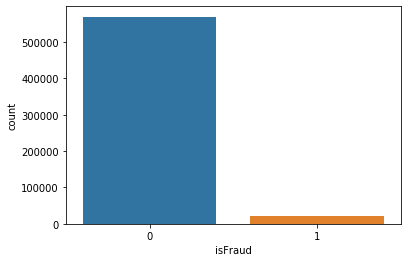

In [9]:
sns.countplot(x="isFraud", data=train_full_df)

In [10]:
len(train_full_df[train_full_df["isFraud"] == 1])/len(train_full_df)*100

3.4990009144173126

So around 3.5% of our data corresponds to fraudulent transactions.

## NA values

Let's analyze the distribution of missing values in our dataset.

Text(0, 0.5, 'Percentage missing')

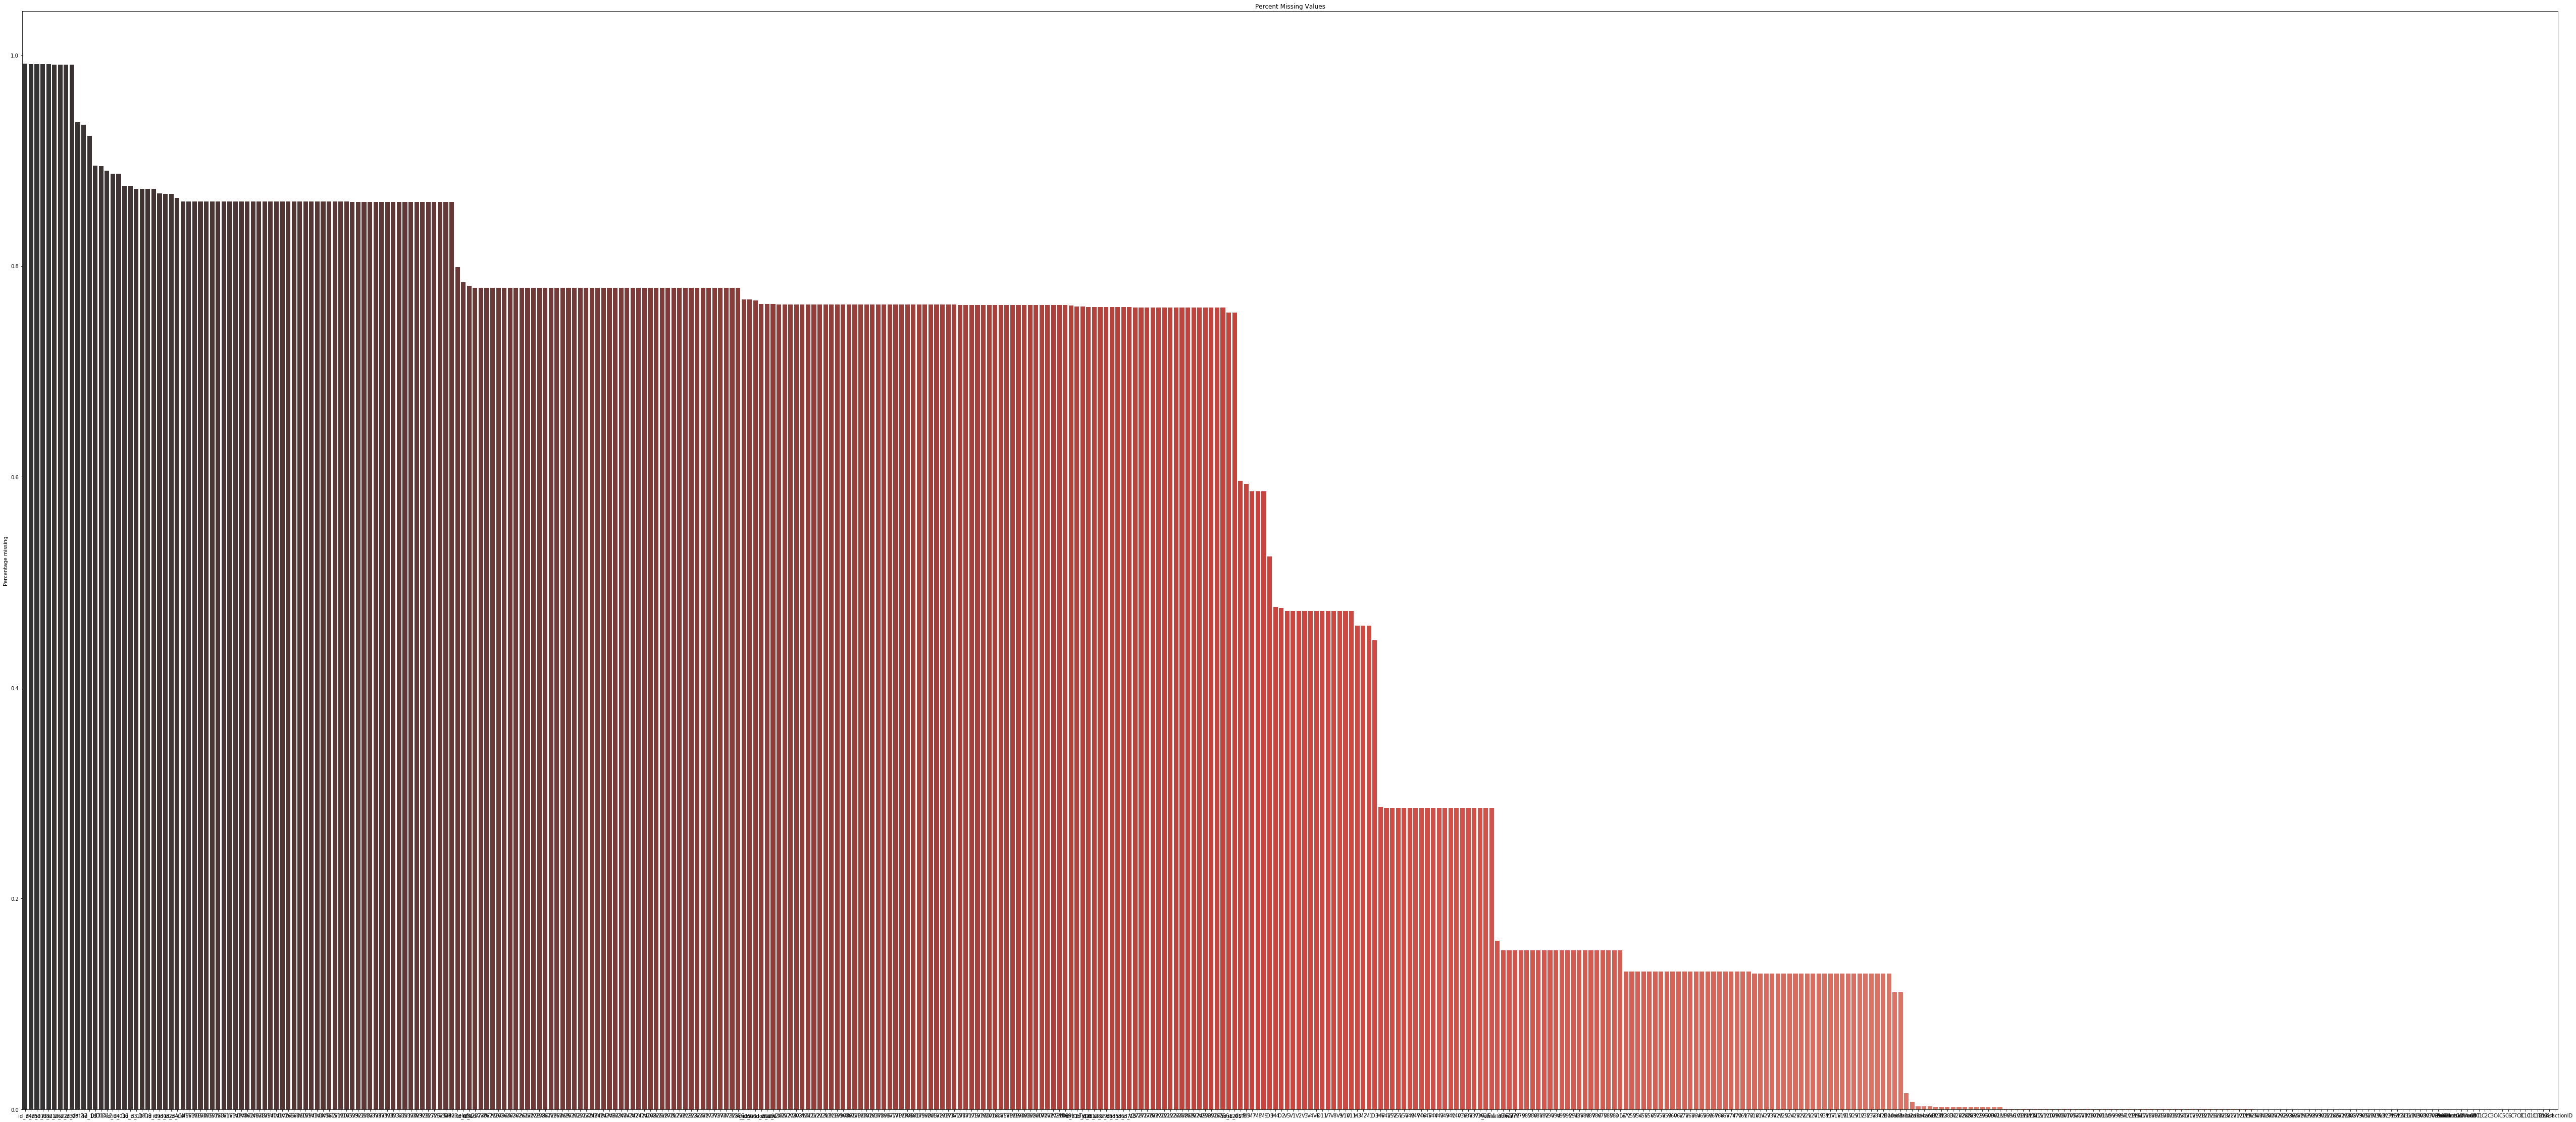

In [11]:
plt.figure(figsize=(90, 40))
sns.barplot(y=train_full_df.isnull().sum().sort_values(ascending=False)/len(train_full_df),
       x=train_full_df.isnull().sum().sort_values(ascending=False).index,
       palette = "Reds_d")
plt.title("Percent Missing Values")
plt.ylabel("Percentage missing")

In [12]:
columns_nas = pd.DataFrame({"na_count": train_full_df.isnull().sum().sort_values(ascending=False)})
columns_nas["percentage"] = columns_nas["na_count"]/len(train_full_df)

In [13]:
# only tolerate up to 15% missing values
limit = 0.15
columns_to_keep = columns_nas[columns_nas["percentage"] <= limit].index
train_full_df = train_full_df[train_full_df.columns.intersection(columns_to_keep)]

In [14]:
train_full_df.shape

(590540, 160)

## Categorical Variables

Next, we need to encode the categorical variables.

In [15]:
train_full_df[train_full_df.select_dtypes(include="object").columns].head()

,ProductCD,card4,card6
0,W,discover,credit
1,W,mastercard,credit
2,W,visa,debit
3,W,mastercard,debit
4,H,mastercard,credit


In [17]:
ProductCD_dummies = pd.get_dummies(train_full_df["ProductCD"])
card4_dummies = pd.get_dummies(train_full_df["card4"])
card6_dummies = pd.get_dummies(train_full_df["card6"])

In [19]:
train_full_df = pd.concat([train_full_df, ProductCD_dummies,
                          card4_dummies, card6_dummies], axis = 1)
train_full_df.shape

(590540, 173)

We now drop the categorical columns and the rows which still have missing values. Naturally this also leads to a reduction of the number of fraudulent transactions we keep.

In [20]:
train_full_df = train_full_df._get_numeric_data()
train_full_df = train_full_df.dropna()
print("Percentage of fraudulent transactions:",
     len(train_full_df[train_full_df["isFraud"]==1])/len(train_full_df)*100)

Percentage of fraudulent transactions: 2.04579077462003


In [21]:
train_full_df.shape

(437337, 170)

In [22]:
x_full_df = train_full_df.drop(["isFraud"], axis=1)
y_full_df = train_full_df["isFraud"]

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test =train_test_split(x_full_df, y_full_df,
                                                  test_size = 0.2)

## Modeling

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [25]:
lr = LogisticRegression(solver="lbfgs", max_iter = 1000,
                        class_weight="balanced")
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
lr.score(x_test, y_test)

0.8228380664928888

In [27]:
y_pred = lr.predict(x_test)

In [28]:
pd.crosstab(y_test, y_pred, rownames=["True"], colnames=["Predicted"], margins = True)

Predicted,0,1,All
True,,,
0,71189,14521,85710
1,975,783,1758
All,72164,15304,87468


In [29]:
recall_score(y_test, y_pred)

0.4453924914675768

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score

In [34]:
y_pred_proba = lr.predict_proba(x_test)
y_pred_proba

array([[0.54271865, 0.45728135],
       [0.61194978, 0.38805022],
       [0.55933665, 0.44066335],
       ...,
       [0.51344701, 0.48655299],
       [0.60126191, 0.39873809],
       [0.68695558, 0.31304442]])

In [36]:
y_pred_proba[:,1]

array([0.45728135, 0.38805022, 0.44066335, ..., 0.48655299, 0.39873809,
       0.31304442])

In [37]:
roc_curve(y_test, y_pred_proba[:,1])

(array([0.00000000e+00, 1.16672500e-05, 1.16672500e-05, ...,
        9.99649982e-01, 9.99649982e-01, 1.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 5.68828214e-04, ...,
        9.99431172e-01, 1.00000000e+00, 1.00000000e+00]),
 array([2.00000000e+00, 9.99999998e-01, 9.99999997e-01, ...,
        2.46787675e-02, 2.38570743e-02, 2.75316100e-05]))

In [39]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.7020981405535958

## Cross validation

Let's see if we can improve our performance with cross validation.

In [40]:
from sklearn.linear_model import LogisticRegressionCV
lr_cv = LogisticRegressionCV(cv = 5, scoring="roc_auc", max_iter=1000,
                            class_weight="balanced", n_jobs=4)
lr_cv.fit(x_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='warn', n_jobs=4, penalty='l2',
                     random_state=None, refit=True, scoring='roc_auc',
                     solver='lbfgs', tol=0.0001, verbose=0)

In [41]:
lr_cv.score(x_test, y_test)

/anaconda3/envs/dl_pytorch/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:2257: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


0.707705707621369

In [42]:
y_cv_pred = lr_cv.predict(x_test)

In [43]:
pd.crosstab(y_test, y_cv_pred, rownames=["True"], colnames=["Predicted"], margins = True)

Predicted,0,1,All
True,,,
0,71684,14026,85710
1,985,773,1758
All,72669,14799,87468


In [44]:
recall_score(y_test, y_cv_pred)

0.4397042093287827

In [48]:
y_pred_proba_cv = lr_cv.predict_proba(x_test)

In [49]:
y_pred_proba_cv

array([[0.53968685, 0.46031315],
       [0.59566562, 0.40433438],
       [0.55566271, 0.44433729],
       ...,
       [0.51502919, 0.48497081],
       [0.59362845, 0.40637155],
       [0.67128868, 0.32871132]])

In [50]:
roc_auc_score(y_test, y_pred_proba_cv[:,1])

0.707705707621369

## Write to csv for Kaggle submission

In [51]:
import csv

In [67]:
test_identity = pd.read_csv("test_identity.csv")
test_transaction = pd.read_csv("test_transaction.csv")

In [68]:
# Merge the two dfs by TransactionID
test_full_df = pd.merge(test_transaction, test_identity, on = "TransactionID", how="left")

In [69]:
del test_identity, test_transaction

In [70]:
test_full_df.shape

(506691, 433)

In [71]:
test_ProductCD_dummies = pd.get_dummies(test_full_df["ProductCD"])
test_card4_dummies = pd.get_dummies(test_full_df["card4"])
test_card6_dummies = pd.get_dummies(test_full_df["card6"])

In [77]:
test_full_df = pd.concat([test_full_df, test_ProductCD_dummies,
                        test_card4_dummies, test_card6_dummies], axis = 1)

In [78]:
test_full_df = test_full_df._get_numeric_data()

In [86]:
test_full_df_nona = pd.DataFrame(test_full_df, 
                                 columns=x_full_df.columns)
test_full_df_nona.shape

(506691, 169)

In [87]:
test_full_df_nona.isnull().sum().sort_values(ascending=False)

debit or credit    506691
addr1               65609
addr2               65609
V71                 12899
V54                 12899
                    ...  
V117                    0
V118                    0
V119                    0
V120                    0
TransactionID           0
Length: 169, dtype: int64

In [88]:
test_full_df_nona["debit or credit"] = 0

In [89]:
test_full_df_nona.isnull().sum().sort_values(ascending=False)

addr1            65609
addr2            65609
V61              12899
V71              12899
V53              12899
                 ...  
V117                 0
V118                 0
V119                 0
V120                 0
TransactionID        0
Length: 169, dtype: int64

In [90]:
test_full_df_nona = test_full_df_nona.fillna(test_full_df_nona.mean())

In [91]:
test_full_df_nona.isnull().sum().sort_values()

TransactionID      0
V132               0
V133               0
V134               0
V135               0
                  ..
V63                0
V64                0
V65                0
V57                0
debit or credit    0
Length: 169, dtype: int64

In [92]:
y_kaggle = lr_cv.predict_proba(test_full_df_nona)

In [100]:
y_kaggle

array([[0.66430259, 0.33569741],
       [0.56832696, 0.43167304],
       [0.45372386, 0.54627614],
       ...,
       [0.58042291, 0.41957709],
       [0.56788765, 0.43211235],
       [0.58508048, 0.41491952]])

In [96]:
test_transaction = pd.read_csv("test_transaction.csv")
test_ID = test_transaction["TransactionID"]

In [97]:
csv_data = pd.DataFrame({"TransactionID" : test_ID,
                        "isFraud" : y_kaggle[:,1]})

In [98]:
csv_data.head()

,TransactionID,isFraud
0,3663549,0.335697
1,3663550,0.431673
2,3663551,0.546276
3,3663552,0.497171
4,3663553,0.493543


In [101]:
with open('submission.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(csv_data)
    
csv_file.close()

In [102]:
csv_data.to_csv(r'submission2.csv', 
                index=False, header=True)

In [103]:
csv_data.shape

(506691, 2)